# Implementação de Máquinas de Vetores Suporte em Julia

   Este capítulo é dedicado a alguns experimentos númericos cujo objetivo é visualizar na prática a implementação da técnica das Máquinas de Vetores de Suporte (SVM), possibilitando assim analisar as particularidades da sua implementação juntamente com referencial teórico matemático desenvolvido no capítulo anterior. 
   
   Para desenvolvimento desses experimentos utilizaremos o *software* de programação Julia em sua versão 1.4.0, além dos pacotes ``Plots`` para gerar as imagens, ``JuMP`` e ``Ipopt`` para resolução dos problemas de otimização, ``RDatasets`` para ter acesso ao conjunto de dados Iris e o pacote ``DataFrame`` para gerar algumas tabelas de dados.
   
   Como abordado anteriormente, Máquinas de Vetores de Suporte é um algoritmo de Aprendizagem de Máquina muito utilizado para classificação e regressão, e nosso objetivo será sua aplicação em problemas que envolvam a classificação de dados. Primeiramente vamos relembrar que em problemas de classificação estamos interessados, assim como o nome já antecipa, em classificar da melhor maneira possível um determinado conjunto de dados. No caso em que os dados são linearmente separáveis, isto é, existe um hiperplano que os separa corretamente, aplica-se a SVM de margem rígida e o problema costuma ter uma resolução mais simples. Entretanto, os problemas de classificação que envolvem situações reais costumam ser mais elaborados, pois neste caso os dados geralmente não são linearmente separáveis. Nestas situações é necessário utilizar a SVM com margem flexível (C-SVM), se os dados forem, a grosso modo, mais "comportados", ou a SVM não-linear. Este último caso exige um desenvolvimento teórico matemático mais avançado e que foge do escopo deste trabalho e portanto não será abordado, se constituindo numa proposta de estudos a ser desenvolvido em projetos futuros. 
   
   Neste primeiro momento nosso propósito será implementar o algoritmo de SVM num exemplo prático: o conjunto de dados flor Íris. Tal conjunto de dados consiste em 150 amostras de três espécies da planta Iris, sendo 50 amostras da Iris setosa, 50 da Iris virginica e 50 da Iris versicolor. Cada dado amostral contém as medidas de quatro variáveis morfológicas: comprimento e largura das sépalas e das pétalas, medidas em centímetros. É com base nas diferenciações e semelhanças dessas características que é possível distinguir uma espécie da outra. Tais dados foram introduzidos pelo estatístico e biólogo Ronald Fisher em um artigo seu de 1936, e *"através da combinação dessas quatro características ele desenvolveu um modelo discriminante linear para distinguir as espécies".* (informação retirada da wikipedia, fazer citação correta).

   O conjunto de dados Iris é um exemplo clássico utilizado para testes e estudo de técnicas de classificação em Aprendizagem de Máquina, como por exemplo as Máquinas de Vetores de Suporte. Além disso, este conjunto se constitui num bom exemplo para diferenciar técnicas supervisionadas de não-supervisionadas. Por exemplo, para implementar a técnica de SVM na classificação dos dados Iris será fundamental a informação da espécie a qual cada dado de treinamento pertence, de modo que a máquina consiga aprender detectando um padrão entre as características de cada amostra e a espécie a qual ela pertence de fato. Dessa forma o algoritmo irá criar uma função de decisão que permitirá classificar corretamente novos dados. Ou seja, sem a informação da espécie nos dados de treinamento não é possível aplicar tal técnica, e tal informação é coletada por um indivíduo, isto é, há uma supervisão humana. Enquanto que técnicas não-supervisionadas não necessitam que os dados sejam previamente rotulados.

In [1]:
using Pkg
pkg"add RDatasets"
pkg"add JuMP"
pkg"add Ipopt"
pkg"add Plots"
pkg"add StatsBase"
pkg"add DataFrames"
pkg"add CSV"

   Updating registry at `C:\Users\paula\.julia\registries\General`
   Updating git-repo `https://github.com/JuliaRegistries/General.git`

Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versi

In [2]:
using RDatasets, JuMP, Ipopt, Random, LinearAlgebra, Plots, StatsBase, DataFrames, CSV

   Primeiramente, é preciso importar o conjunto de dados Iris. Perceba que as amostras pertencem a três diferentes espécies: Iris setosa, Iris versicolor e Iris virginica. Nosso objetivo aqui será aprender a separar a espécie setosa das demais.

In [33]:
iris = dataset("datasets", "iris")
levels(iris[!,:Species])

3-element Array{String,1}:
 "setosa"
 "versicolor"
 "virginica"

   Pretendemos inicialmente modelar o problema que compreende apenas duas características, isto é, o conjunto de entrada $\mathcal{X} = \{x^{1} , \ldots , x^{p} \} \subset \mathbb{R}^{2}$. Assim, podemos representar o conjunto de dados através de uma matriz $X^{150\times 2}$, em que cada linha corresponde a um vetor $x^{i}$, ou seja, um dado amostral. O vetor $Y$ por sua vez contém a correta classificação de cada dado em relação a sua espécie, a qual é representada numericamente. Logo, amostras da espécie setosa serão classificadas como $1$, enquanto que amostras das espécies versicolor ou virginica serão classificadas em $-1$.

In [34]:
X = convert(Array,iris[:, 1:2]) 
p, n = size(X)

(150, 2)

In [35]:
# SVM format expects positive and negative examples to +1/-1
Y = [species == "setosa" ? 1.0 : -1.0 for species in iris[!,:Species]]

150-element Array{Float64,1}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0

   Na tabela a seguir é possível visulizar o conjunto de dados com mais clareza, tendo as características de cada amostra e sua respectiva classificação especificadas.

In [36]:
iris_df = DataFrame(X);
iris_df.Espécie = Y;
rename!(iris_df, Dict(:x1 => :"Comprimento sépala"))
rename!(iris_df, Dict(:x2 => :"Largura sépala"))

,Comprimento sépala,Largura sépala,Espécie
,Float64,Float64,Float64
1,5.1,3.5,1.0
2,4.9,3.0,1.0
3,4.7,3.2,1.0
4,4.6,3.1,1.0
5,5.0,3.6,1.0
6,5.4,3.9,1.0
7,4.6,3.4,1.0
8,5.0,3.4,1.0
9,4.4,2.9,1.0


Assim, nosso objetivo será classificar o conjunto de dados acima em setosa e não setosa. Tal classificação será feita com base nas características "comprimento de sépala" e "largura de sépala". Mas antes de formular o problema matematicamente, vamos analisar o gráfico que representa tais dados em relação às duas características citadas. 

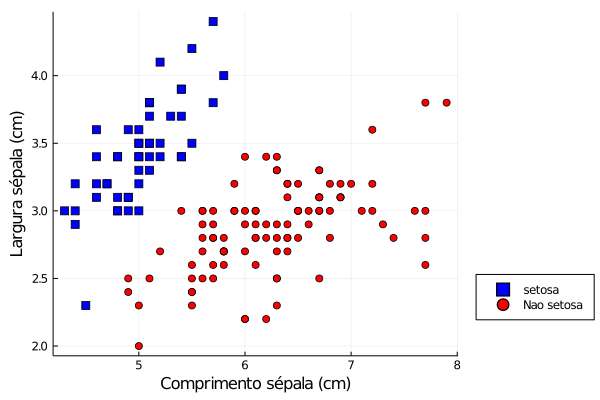

In [37]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,2], c=:blue, m=:square, label = "setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle, label = "Nao setosa", legend=:outerbottomright)
plot!(xlabel="Comprimento sépala (cm)", ylabel="Largura sépala (cm)")

   No gráfico acima estão representados os 150 pontos que correpondem aos nossos dados amostrais, em que os pontos em azul representam a espécie setosa, isto é, os vetores $x^{i}$ tais que $y_{i} = 1$, e os pontos em vermelho as espécies versicolor e virginica que correspondem aos vetores $x^{i}$ tais que $y_{i} = -1$. 

   Como abordado no capítulo anterior, a modelagem do problema de classificação utilizando a técnica de SVM consiste em determinar o hiperplano que melhor separa os dados, classificando-os assim em duas classes. Desse modo, analisando atentamente o gráfico acima pode-se intuir que é possível separar os dados através de um hiperplano, que neste caso será uma reta, pois os dados pertencem ao $\mathbb{R}^{2}$. 

   Ademais, como já demonstrado (citar seção), o hiperplano ótimo é aquele que maximiza a margem que não contenha nenhum dado. Logo, desejamos que os pontos $x^{i}$ satisfaçam a seguinte restrição

$$
y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 150,
$$

e portanto, o problema de encontrar o hiperplano ótimo $\mathcal{H}(w,b)$ é formulado da seguinte forma

\begin{aligned}
\min_{w,b} & \quad \dfrac{1}{2} \Vert w\Vert^{2} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 150, 
\end{aligned}

em que, neste exemplo, $w \in \mathbb{R}^{2}$ e $b\in \mathbb{R}$. 

In [38]:
Random.seed!(0)
trainsize = 30 # Esta é a quantidade de dados que irá compor o conjunto de treinamento.
train_set = sample(1:p,trainsize,replace=false,ordered=true) # Lembre, p=150 é o número total de dados amostrais. Neste comando estamos pedindo para selecionar 30 dados aleatoriamente, e "replace" é para selecionar números diferentes.
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = Y[train_set]
Xtest = X[test_set,:]
Ytest = Y[test_set]
ptrain = length(Ytrain)

30

Observe que os 150 dados foram divididos em dois conjuntos, o conjunto de treinamento, com 30 dados, e o conjunto de teste, com os 120 dados restantes. É através do conjunto de treinamento que o algoritmo de SVM irá "aprender" a classificar os dados detectando padrões entre suas características e a espécie a qual pertencem. Já o conjunto de teste será utilizado para verificar se o classificador encontrado, isto é, o hiperplano ótimo, é bom, averiguando se os dados de teste são classificados corretamente, uma vez que suas saídas já são conhecidas.

A seguir, utilizando o modelo matemático formulado no capítulo anterior, vamos resolver o problema de classificação. 

In [39]:
model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:n]) # Aqui declaramos as variáveis.
@variable(model, b)

@objective(model, Min, dot(w, w) / 2) # Esta é a função objetivo.

@constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b) ≥ 1) # Esta é a restrição.

# print(model) 
optimize!(model)

w, b = value.(w), value.(b) # Com este comando queremos que os valores ótimos sejam apresentados.

([-3.9999999608694576, 4.9999999508060435], 5.599999946154862)

   Assim, resolvendo o problema (citar) encontramos os valores ótimos para $w$ e $b$, que então representados acima respectivamente, e que definem o hiperplano ótimo. Para melhor visualizar a classificação dos dados de treinamento vamos representá-los graficamente a seguir junto ao hiperplano ótimo.

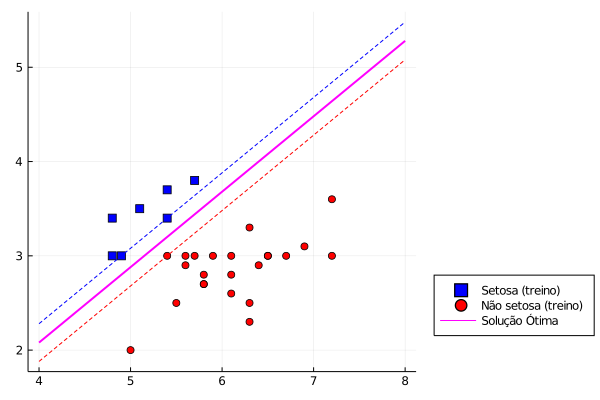

In [40]:
I = findall(Ytrain .== 1)
scatter(Xtrain[I,1], Xtrain[I,2], c=:blue, m=:square, label = "Setosa (treino)", legend=:outerbottomright)
I = findall(Ytrain .== -1)
scatter!(Xtrain[I,1], Xtrain[I,2], c=:red, m=:circle, label = "Não setosa (treino)")
# plot!(leg=false)
plot!(x -> -(w[1] * x + b) / w[2], 4, 8, c=:magenta, lw=:2,label = "Solução Ótima")
plot!(x -> -(w[1] * x + b - 1) / w[2], 4, 8, c=:blue, l=:dash,label = "")
plot!(x -> -(w[1] * x + b + 1) / w[2], 4, 8, c=:red, l=:dash,label = "")

Portanto, no gráfico acima a reta magenta corresponde ao hiperplano ótimo e as retas tracejadas são os hiperplanos que delimitam a máxima margem possível. Observe que de fato o conjuto de dados de treinamento é linearmente separável, pois o hiperplano ótimo os está separando corretamente. 

No entando, para analisar se o classificador encontrado é realmente bom é necessário ainda verificar se ele irá classificar corretamente os dados do conjunto de teste.

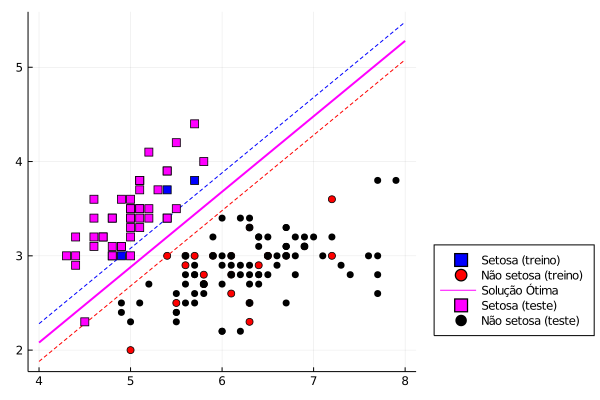

In [41]:
I = findall(Ytest .== 1)
scatter!(Xtest[I,1], Xtest[I,2], c=:magenta, m=:square, label = "Setosa (teste)", legend=:outerbottomright)
I = findall(Ytest .== -1)
scatter!(Xtest[I,1], Xtest[I,2], c=:black, m=:circle, label = "Não setosa (teste)")

Infelizmente, pode-se perceber que o hiperplano encontrado como solução do nosso problema não classifica corretamente todos os dados do conjunto de teste, pois há um ponto pertencente a espécie setosa que de acordo com o hiperplano representado no gráfico acima seria classificado como não setosa. 

Para verificar de modo mais eficiente se o classificador encontrado é bom, basta então comparar o rótulo correto de cada dado de teste com a sua classificação recebida pelo hiperplano encontrado.

In [42]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)
@show all(Ytest[Setosa] .== 1)
@show all(Ytest[Nonsetosa] .== -1)

all(Ytest[Setosa] .== 1) = true
all(Ytest[Nonsetosa] .== -1) = false


false

De fato, o retorno `false` acima nos afirma que nem todos os dados classificados como $-1$ são da espécie não setosa, devido ao dado classificado incorretamente.

Em vista disso, e no intuito de obter um bom classificador, vamos agora aplicar a técnica de SVM com margem flevível (C-SVM) para classificar o conjunto de dados Iris e analisar se dessa forma é possível obter uma classificação correta.
Neste caso, promovemos um relaxamento das restrições do nosso problema de otimização na tentativa de conseguir classificar corretamente os dados que não estejam no semiespaço correto. Tal relaxamento é feito acrescentando-se variáveis de folga $\xi_{i}$ às restrições. Entretanto, o ideal é que a maior quantidade de dados esteja localizado no semiespaço correto, isto é, que o maior número possível de variáveis de folga seja igual a zero. Em outras palavras, desejamos minimizar também os valores das variáveis de folga. Para tanto, acrescentamos à nossa função objetivo do problema de classificação o somatório das variáveis $\xi_{i} \geq 0$ multiplicado por um parâmetro $C >0$. Tal parâmetro nada mais é do que uma penalização aos valores dos $\xi_{i}$.

Assim, de acordo com o desenvolvido em capítulos anteriores, podemos reformular nosso problema da seguinte maneira

\begin{aligned}
\min_{w,b, \xi} & \quad \dfrac{1}{2} \Vert w\Vert^{2} + C\sum_{i=1}^{p} \xi_{i} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1 - \xi_{i} , \quad i=1, \ldots , p, \\
& \quad \xi_{i} \geq 0 , \quad i=1, \ldots , p. 
\end{aligned}

em que $w \in \mathbb{R}^{2}$, $b\in \mathbb{R}$ e $C >0$. 

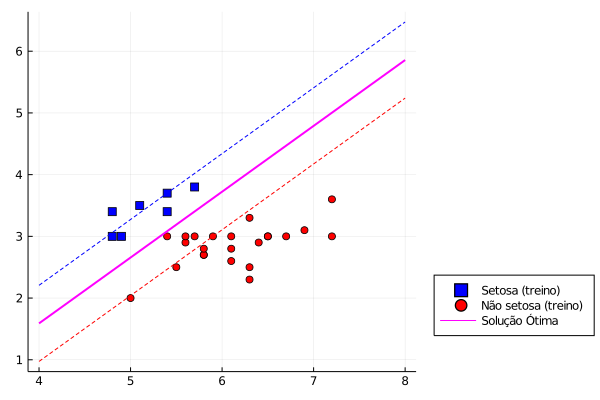

In [43]:
C = 1.0
model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:n]) # Aqui declaramos as variáveis.
@variable(model, b)
@variable(model, ξ[1:ptrain] ≥ 0)

@objective(model, Min, dot(w, w) / 2 + C * sum(ξ)) # Esta é a função objetivo.

@constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b)  ≥ 1- ξ[i]) # Esta é a restrição.

# print(model) 
optimize!(model)

w, b, ξ = value.(w), value.(b), value.(ξ) #aqui queremos desenhar os valores ótimos

I = findall(ξ .> 1e-6) 
scatter!(Xtrain[I,1], Xtrain[I,2], c=:green, m=(:white, stroke(1,:green), 10))
I = findall(Ytrain .== 1)
scatter(Xtrain[I,1], Xtrain[I,2], c=:blue, m=:square, label = "Setosa (treino)", legend=:outerbottomright)
I = findall(Ytrain .== -1)
scatter!(Xtrain[I,1], Xtrain[I,2], c=:red, m=:circle, label = "Não setosa (treino)")
# plot!(leg=false)
plot!(x -> -(w[1] * x + b) / w[2], 4, 8, c=:magenta, lw=:2,label = "Solução Ótima")
plot!(x -> -(w[1] * x + b - 1) / w[2], 4, 8, c=:blue, l=:dash,label = "")
plot!(x -> -(w[1] * x + b + 1) / w[2], 4, 8, c=:red, l=:dash,label = "")

In [43]:
w, b, ξ

([-1.729729673685581, 1.6216216639906027], 4.340540081955011, [0.0, 0.2702703196384318, 0.0, 0.35675672739441433, 0.0, 0.4864864908849812, 0.09729735226987311, 0.0, 0.0, 0.0  …  0.3459459264249114, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

   Temos representada acima a solução do problema utilizando SVM com margem flexível, e observe que esta solução é diferente da encontrada anteriormente. De fato, é possível perceber que neste caso os vetores que apresentam $\xi_{i} > 0$ possuem uma maior "liberdade", de modo que possam estar localizados na região entre as margens e o hiperplano separador. Em vista disso, é importante ressaltar que caso o valor atribuído ao parâmetro de penalização $C$ seja pequeno, uma maior quantidade de vetores recebe folga, inclusive alguns para os quais não seria necessário. Caso contrário, se valores muito altos são atribuídos ao parâmetro $C$, o número de vetores que recebe folga diminui. Contudo, neste último caso o programa tende a se concentrar em minimizar a penalização em vez da margem na função objetivo. Em decorrência disso, é de suma importância escolher o valor correto para o parâmetro $C$. Neste exemplo em particular, o valor de $C$ que possibilitou a melhor classificação foi $C=1$.

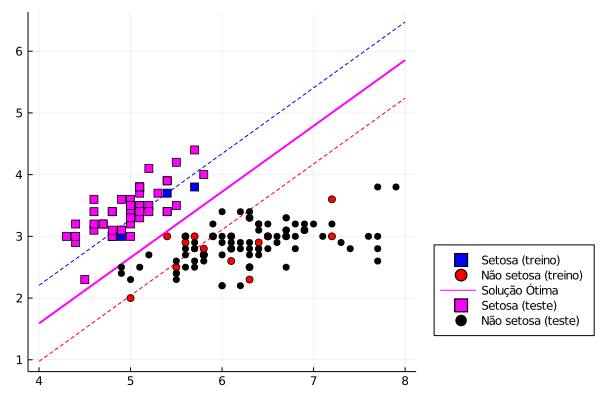

In [44]:
I = findall(Ytest .== 1)
scatter!(Xtest[I,1], Xtest[I,2], c=:magenta, m=:square, label = "Setosa (teste)", legend=:outerbottomright)
I = findall(Ytest .== -1)
scatter!(Xtest[I,1], Xtest[I,2], c=:black, m=:circle, label = "Não setosa (teste)")

In [45]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)
@show all(Ytest[Setosa] .== 1)
@show all(Ytest[Nonsetosa] .== -1)

all(Ytest[Setosa] .== 1) = true
all(Ytest[Nonsetosa] .== -1) = true


true

Portanto, permitindo um relaxamento das restrições através da técnica de C-SVM foi possível determinar um hiperplano ótimo que classifique corretamente todos os dados, tanto de treinamento quanto de teste, como é possível verificar acima. 

Por fim, para finalizar os experimentos numéricos com o conjunto de dados Iris, vamos analisar agora a classificação deste conjunto levando em consideração quatro características.

In [46]:
X = convert(Array,iris[:, 1:4]) # mudar de 2 para 4 para característivas
p, n = size(X)

(150, 4)

In [47]:
Y = [species == "setosa" ? 1.0 : -1.0 for species in iris[!,:Species]];

In [48]:
iris_df = DataFrame(X);
iris_df.Espécie = Y;
names(iris_df);
rename!(iris_df, Dict(:x1 => :"Comp. sépala"))
rename!(iris_df, Dict(:x2 => :"Largura sépala"))
rename!(iris_df, Dict(:x3 => :"Comp. pétala"))
rename!(iris_df, Dict(:x4 => :"Largura pétala"))

,Comp. sépala,Largura sépala,Comp. pétala,Largura pétala,Espécie
,Float64,Float64,Float64,Float64,Float64
1,5.1,3.5,1.4,0.2,1.0
2,4.9,3.0,1.4,0.2,1.0
3,4.7,3.2,1.3,0.2,1.0
4,4.6,3.1,1.5,0.2,1.0
5,5.0,3.6,1.4,0.2,1.0
6,5.4,3.9,1.7,0.4,1.0
7,4.6,3.4,1.4,0.3,1.0
8,5.0,3.4,1.5,0.2,1.0
9,4.4,2.9,1.4,0.2,1.0


Na tabela acima, a primeira coluna apresenta uma numeração dos dados, as quatro colunas que vêm em seguida correspondem as diferentes características de cada dado amostral, e a última corresponde a espécie correta a qual o dado pertence, sendo classificada como 1 se é da espécie setosa e -1 caso contrário, assim como no exemplo anterior. A principal diferença agora é que o conjunto de entrada $\mathcal{X} = \{x^{1} , \ldots , x^{p} \} \subset \mathbb{R}^{4}$.

Desse modo, vamos analisar os gráficos que representam as espécie setosa e não setosa de acordo com duas características de cada vez.

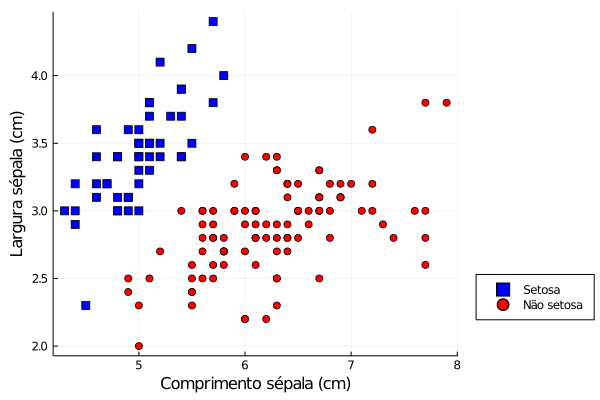

In [49]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,2], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="Comprimento sépala (cm)", ylabel="Largura sépala (cm)")

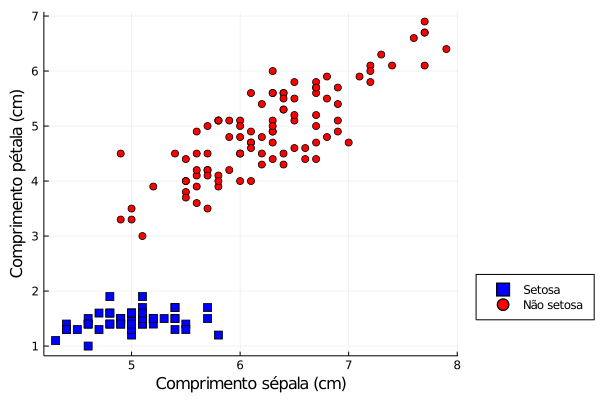

In [50]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,3], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,3], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="Comprimento sépala (cm)", ylabel="Comprimento pétala (cm)")

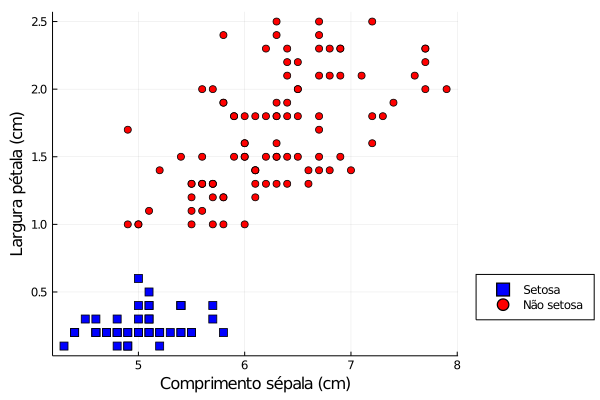

In [51]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,4], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,4], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="Comprimento sépala (cm)", ylabel="Largura pétala (cm)")

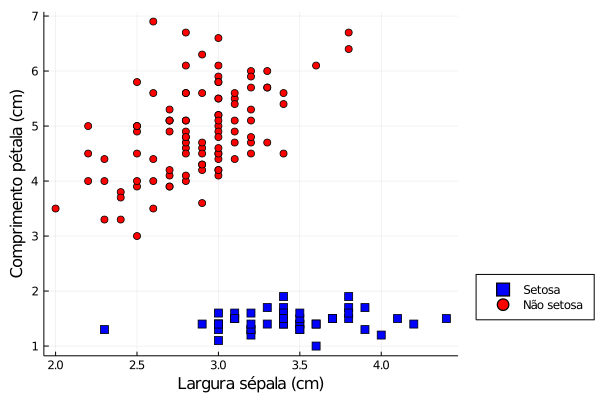

In [52]:
I = findall(Y .== 1)
scatter(X[I,2], X[I,3], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,2], X[I,3], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="Largura sépala (cm)", ylabel="Comprimento pétala (cm)")

Nos gráficos acima temos a representação dos dados amostrais de acordo com suas características, sendo que os dados em azul pertencem à espécie setosa e os dados em vermelho às espécies versicolor e virginica.

Analisando tais gráficos percebe-se que em cada um deles os dados aparentam ser linearmente separáveis. Assim, para construir o modelo do nosso problema novamente vamos dividir aleatoriamente os dados entre o conjunto de treinamento e o conjunto de teste.

In [53]:
Random.seed!(0)
trainsize = 30 # Esta é a quantidade de dados que irá compor o conjunto de treinamento.
train_set = sample(1:p,trainsize,replace=false,ordered=true) # Lembre, p=150 é o número total de dados amostrais. Neste comando estamos pedindo para selecionar 30 dados aleatoriamente, e "replace" é para selecionar números diferentes.
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = Y[train_set]
Xtest = X[test_set,:]
Ytest = Y[test_set]
ptrain = length(Ytrain)

30

Tendo definido os conjuntos de treino e teste, vamos agora construir nosso modelo matemático utilizando a técnica de SVM.

In [54]:
model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:n]) # Aqui declaramos as variáveis.
@variable(model, b)

@objective(model, Min, dot(w, w) / 2) # Esta é a função objetivo.

@constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b) ≥ 1) # Esta é a restrição.

# print(model) 
optimize!(model)

w, b = value.(w), value.(b) # Com este comando queremos que os valores ótimos sejam apresentados.

([-0.23049982221726428, 0.36721475450118474, -0.6954627616094768, -0.40882369457746726], 2.2610129614615118)

Agora, vamos avaliar se o classificador encontrado é bom, isto é, se ele separa os dados corretamente. Para tanto, comparamos a classificação que os dados de teste obtiveram com a sua classsificação correta.

In [55]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)
@show all(Ytest[Setosa] .== 1)
@show all(Ytest[Nonsetosa] .== -1);

all(Ytest[Setosa] .== 1) = true
all(Ytest[Nonsetosa] .== -1) = true


Portanto, para o problema que considera as quatro características dos dados amostrais temos que a técnica de SVM de margem rígida nos fornece um hiperplano que atua como um bom classificador, separando corretamente todos os dados, tanto de treinamento quanto de teste.

## Implementação de SVM para Classificação de Dados de Câncer de Mama

In [56]:
col_headers = ["id" ,"diagnosis" ,"radius_mean" ,"texture_mean" ,"perimeter_mean" ,"area_mean" ,"smoothness_mean" ,"compactness_mean" ,"concavity_mean" ,"concave points_mean" ,"symmetry_mean" ,"fractal_dimension_mean" ,"radius_se" ,"texture_se" ,"perimeter_se" ,"area_se" ,"smoothness_se" ,"compactness_se" ,"concavity_se" ,"concave points_se" ,"symmetry_se" ,"fractal_dimension_se" ,"radius_worst" ,"texture_worst" ,"perimeter_worst" ,"area_worst" ,"smoothness_worst" ,"compactness_worst" ,"concavity_worst" ,"concave points_worst" ,"symmetry_worst" ,"fractal_dimension_worst"]
dfcancer = CSV.File("cancer_data.csv", header = col_headers,);
cancer_df = DataFrame(dfcancer)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
,Int64,String,Float64,Float64,Float64,Float64,Float64
1,842302,M,17.99,10.38,122.8,1001.0,0.1184
2,842517,M,20.57,17.77,132.9,1326.0,0.08474
3,84300903,M,19.69,21.25,130.0,1203.0,0.1096
4,84348301,M,11.42,20.38,77.58,386.1,0.1425
5,84358402,M,20.29,14.34,135.1,1297.0,0.1003
6,843786,M,12.45,15.7,82.57,477.1,0.1278
7,844359,M,18.25,19.98,119.6,1040.0,0.09463
8,84458202,M,13.71,20.83,90.2,577.9,0.1189
9,844981,M,13.0,21.82,87.5,519.8,0.1273


In [57]:
X = convert(Array,cancer_df[:, 3:32]) 
p, n = size(X)

(569, 30)

In [58]:
Y = [diagnosis == "M" ? 1.0 : -1.0 for diagnosis in cancer_df[!,:diagnosis]]

569-element Array{Float64,1}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
 -1.0

In [59]:
Random.seed!(0)
trainsize = 300 # Esta é a quantidade de dados que irá compor o conjunto de treinamento.
train_set = sample(1:p,trainsize,replace=false,ordered=true) # Lembre, p=569 é o número total de dados amostrais. Neste comando estamos pedindo para selecionar 300 dados aleatoriamente, e "replace" é para selecionar números diferentes.
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = Y[train_set]
Xtest = X[test_set,:]
Ytest = Y[test_set]
ptrain = length(Ytrain)

300

In [60]:
model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:n]) # Aqui declaramos as variáveis.
@variable(model, b)

@objective(model, Min, dot(w, w) / 2) # Esta é a função objetivo.

@constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b) ≥ 1) # Esta é a restrição.

# print(model) 
optimize!(model)

w, b = value.(w), value.(b) # Com este comando queremos que os valores ótimos sejam apresentados.

([-6.702003144348819, 0.5279617023615304, 1.7769732710899697, -0.09522789061918002, 40.44361144352949, -186.83103508569752, 86.81432999505323, 186.1655859614973, -235.54539293032042, 48.97780437260241  …  0.7716071090457676, -0.43160342711070215, -0.32427234190638654, 0.04518682199858605, 63.7774946594584, -36.5552288360739, 19.147087818834176, 112.33223422475179, 114.49939909484809, 291.942595860775], -70.76251649424059)

In [77]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
@show all(Ytest[Maligno] .== 1)
@show all(Ytest[Benigno] .== -1)

all(Ytest[Maligno] .== 1) = false
all(Ytest[Benigno] .== -1) = false


false

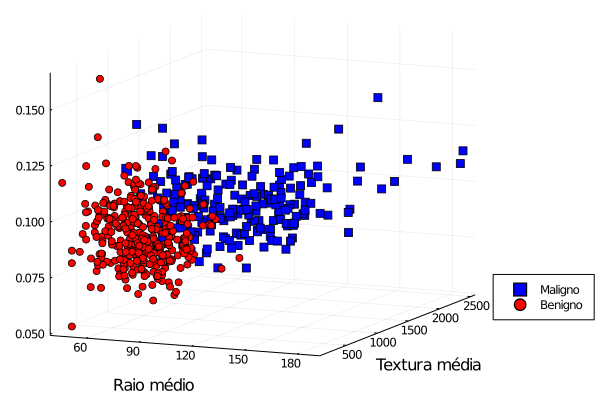

In [69]:
I = findall(Y .== 1)
scatter(X[I,3], X[I,4], X[I,5], c=:blue, m=:square, label = "Maligno")
I = findall(Y .== -1)
scatter!(X[I,3], X[I,4], X[I,5], c=:red, m=:circle, label = "Benigno", legend=:outerbottomright)
plot!(xlabel="Raio médio", ylabel="Textura média")

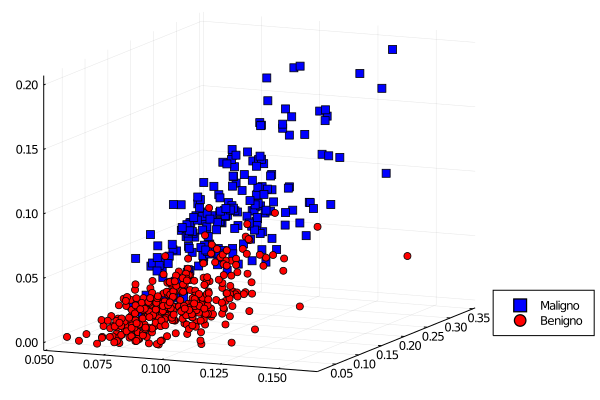

In [72]:
I = findall(Y .== 1)
scatter(X[I,5], X[I,6], X[I,8], c=:blue, m=:square, label = "Maligno")
I = findall(Y .== -1)
scatter!(X[I,5], X[I,6], X[I,8], c=:red, m=:circle, label = "Benigno", legend=:outerbottomright)
#plot!(xlabel="Raio médio", ylabel="Textura média")

In [85]:
C = 1.0
model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:n]) # Aqui declaramos as variáveis.
@variable(model, b)
@variable(model, ξ[1:ptrain] ≥ 0)

@objective(model, Min, dot(w, w) / 2 + C * sum(ξ)) # Esta é a função objetivo.

@constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b)  ≥ 1- ξ[i]) # Esta é a restrição.

# print(model) 
optimize!(model)

w, b, ξ = value.(w), value.(b), value.(ξ)

([-1.1466831940197557, 0.006305534801206432, 0.022517769604120285, 0.0038275360973223523, 0.20828128713221894, 0.23110727162832376, 0.4343235801450901, 0.24523381790075333, 0.27753638737039804, 0.01867288683986131  …  -0.5215814777315732, 0.11584570422859101, 0.14198973519675798, 0.006744224872045417, 0.4336856966148916, 0.7330740058396898, 1.0679572054974291, 0.535933247491887, 0.6598675014512816, 0.06942816846329446], -5.051577960008783, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [86]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
@show all(Ytest[Maligno] .== 1)
@show all(Ytest[Benigno] .== -1)

all(Ytest[Maligno] .== 1) = false
all(Ytest[Benigno] .== -1) = false


false

## Anotações
### Implementação SVM - Margem Rígida

Iniciaremos analisando o caso de SVM com margem rígida. Nesta situação estaremos lidando com dados que são linearmente separáveis e para tanto geramos um conjunto de dados aleatórios que obedeçam a essa característica. Os dados a seguir foram gerados com o pacote ``Random``

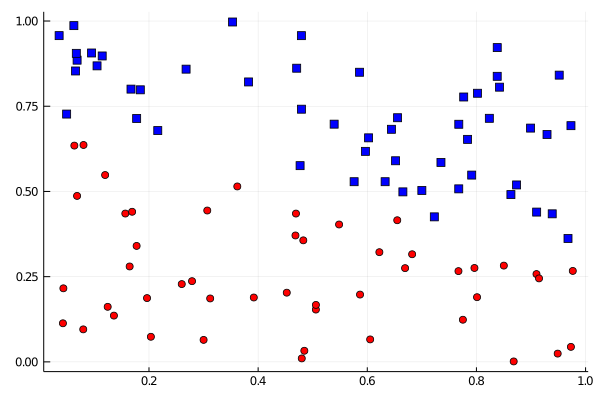

In [71]:
using Plots
gr(size=(600,400))
plot(rand(3),rand(3))
nothing

using Random, LinearAlgebra 

Random.seed!(0)

n = 100 #quantidade de dados
X = rand(n, 2)
w_0 = [0.3; 0.7] 
b_0 = -0.5
y = [dot(w_0, X[i,:]) + b_0 > 0 ? 1 : -1 for i = 1:n]

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

Na imagem acima temos representados 100 pontos que correpondem aos nossos dados, em que os pontos em azul representam os vetores $x^{i}$ tais que $y_{i} = 1$ e os pontos em vermelho correspondem aos vetores $x^{i}$ tais que $y_{i} = -1$. Desse modo, o conjunto de dados é dado por 

$$
\Omega = \{ (x^1, y_1), \ldots , (x^{100}, y_{100})\mid x^i \in \mathbb{R}^{2} \, e \, y_i \in \{-1,1\} \} .
$$

A modelagem do problema de classificação utilizando a técnica de aprendizado SVM consiste em determinar o hiperplano que melhor separa os dados, o que acaba por classificá-los. Assim, o fato de os dados serem linearmente separáveis implica a existência de um hiperplano que os separa corretamente, tanto é que para obtermos os pontos agrupados como na figura acima informamos valores iniciais $w_{0}$ e $b_{0}$ para garantir que os dados fossem linearmente separáveis. No entanto, como veremos mais a frente, esses não serão os valores ótimos do problema. 

Um detalhe importante de se observar é que como os dados pertencem ao $\mathbb{R}^{2}$ o hiperplano será uma reta neste caso. Ademais, como demonstrado no capítulo anterior, o hiperplano ótimo é aquele que maximiza a margem que não contenha nenhum dos dados. Logo, desejamos que os pontos $x^{i}$ também satisfaçam as seguintes restrições 
$$
w^{T}x^{i} + b \geq 1 \quad \text{para} \quad y_{i} = 1
$$
e
$$
w^{T}x^{i} + b \leq -1 \quad \text{para} \quad y_{i} = -1,
$$
que podem ser compactadas da forma
$$
y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 100.
$$

Portanto, com base no que foi desenvolvido em capítulos anteriores, o problema de encontrar o hiperplano ótimo $\mathcal{H}(w,b)$ é formulado da seguinte forma

\begin{aligned}
\min_{w,b} & \quad \dfrac{1}{2} \Vert w\Vert^{2} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 100, 
\end{aligned}

em que, neste exemplo, $w \in \mathbb{R}^{2}$ e $b\in \mathbb{R}$. 

Então, no intuito de solucionar o problema acima descrito utilizando os pacotes ``JuMP`` e ``Ipopt``, vamos primeiramente fazer a sua modelagem.

In [69]:
using JuMP, Ipopt

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:2]) # Aqui declaramos as variáveis.
@variable(model, b)

@objective(model, Min, dot(w, w) / 2) # Esta é a função objetivo.

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1) # Esta é a restrição.

print(model) 

Min 0.5 w[1]² + 0.5 w[2]²
Subject to
 0.8236475079774124 w[1] + 0.7145890517231919 w[2] + b >= 1.0
 0.9103565379264364 w[1] + 0.4394579359338935 w[2] + b >= 1.0
 -0.16456579813368521 w[1] - 0.27989925502310564 w[2] - b >= 1.0
 -0.17732884646626457 w[1] - 0.3401842212195725 w[2] - b >= 1.0
 -0.278880109331201 w[1] - 0.23679985501360878 w[2] - b >= 1.0
 -0.20347655804192266 w[1] - 0.07362716161818517 w[2] - b >= 1.0
 -0.042301665932029664 w[1] - 0.1132182900932166 w[2] - b >= 1.0
 0.06826925550564478 w[1] + 0.8851655573738955 w[2] + b >= 1.0
 -0.3618283907762174 w[1] - 0.5146689804348994 w[2] - b >= 1.0
 0.9732164043865108 w[1] + 0.692970759120777 w[2] + b >= 1.0
 0.5858115517433242 w[1] + 0.8497031958709513 w[2] + b >= 1.0
 0.5392892841426182 w[1] + 0.6974056124492531 w[2] + b >= 1.0
 -0.26003585026904785 w[1] - 0.22823146819255946 w[2] - b >= 1.0
 -0.910046541351011 w[1] - 0.2576252988200516 w[2] - b >= 1.0
 0.16703619444214968 w[1] + 0.8002161278923636 w[2] + b >= 1.0
 0.6554484126999

Com o comando ``print(model)`` obtemos a modelagem do nosso problema, em que as restrições são apresentadas de maneira detalhada. Como é possível observar ele está condizente com o nosso problema proposto originalmente.

Feito isso vamos resolver o problema de classificação.

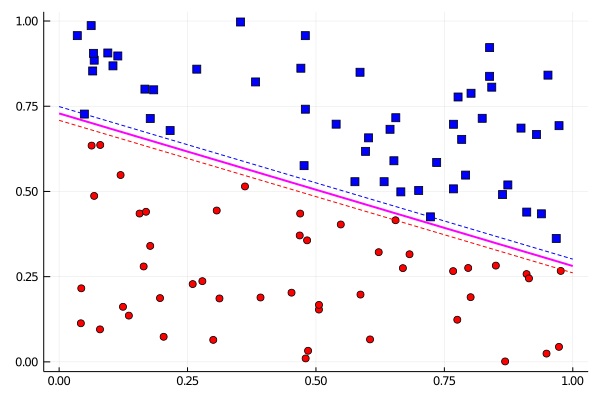

In [46]:
using JuMP, Ipopt

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:2])
@variable(model, b)

@objective(model, Min, dot(w, w) / 2)

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1)

optimize!(model)

w, b = value.(w), value.(b) #aqui queremos desenhar os valores ótimos

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], 0, 1, c=:magenta, lw=:2)
plot!(x -> -(w[1] * x + b - 1) / w[2], 0, 1, c=:blue, l=:dash)
plot!(x -> -(w[1] * x + b + 1) / w[2], 0, 1, c=:red, l=:dash)

Analisando a imagem acima temos representado o hiperplano ótimo que melhor classifica esses dados, assim como os hiperplanos da margem. Além disso, os valores ótimos para $w$ e $b$ são:

In [17]:
w, b

([22.1839900956983, 49.56328710292937], -36.12262702012526)

Note que tais valores são bem diferentes daqueles que estabelecemos para $w_{0}$ e $b_{0}$ inicialmente.

In [72]:
w_0, b_0

([0.3, 0.7], -0.5)

Por conseguinte, algumas observações podem ser feitas sobre a figura acima. Note que os vetores (dados) que estão sobre os hiperplanos da margem são os que se encontram no estado mais crítico e devido a isso são eles que de fato definem o hiperplano separador. Em outras palavras, tais vetores dão suporte ao hiperplano ótimo, de modo que todos os demais vetores poderiam ser descartados sem causar alteração. E temos assim de onde deriva o nome dessa técnica de aprendizagem de máquina supervisionada, Máquinas de Vetores Suporte.

No entanto, como mencionado anteriormente, em problemas que envolvam situações reais os dados não costumam ser linearmente separáveis e assim, não existe um hiperplano separador que classifica os dados corretamente. Em vista disso, vamos analisar o caso em que os dados apresentam uma margem flexível e desenvolver o problema de classificação com margem flexível (C-SVM).

$%Neste caso, se submetermos dados não-linearmente separáveis ao método anterior ele falha, pois nem todos os dados irão obedecer as restrições impostas a função objetivo. Para tanto, vamos desenvolver para o caso SVM de margem flexível.$

### CSVM - Margem flexível

Vamos considerar agora um conjunto de dados não-linearmente separáveis, mas digamos ligeiramente comportados, como os representados a seguir.

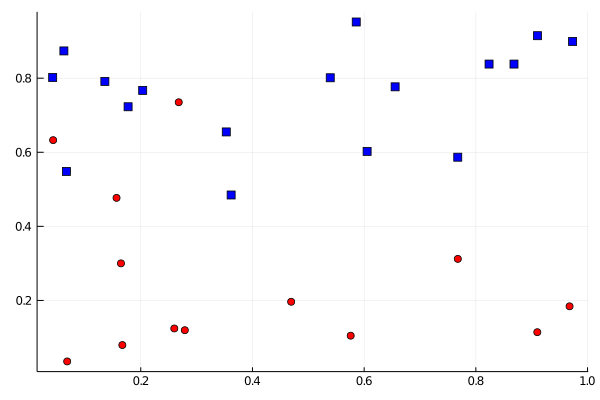

In [78]:
using Random, LinearAlgebra

Random.seed!(0)

n = 30 
X = rand(n, 2)
w_o = [0.3; 0.7]
b_o = -0.5
y = [dot(w_sol, X[i,:]) + b_sol > randn() * 0.1 ? 1 : -1 for i = 1:n] 

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

Observando a figura acima percebe-se que não é possível traçar um hiperplano que separe os dados azuis dos vermelhos corretamente. Em decorrência disso, promovemos um relaxamento das restrições na tentativa de conseguir classificar corretamente os dados que não estejam no semiespaço correto. Tal relaxamento é feito acrescentando-se variáveis de folga $\xi_{i}$ às restrições.

No entanto, o ideal é que a maior quantidade de dados esteja localizado no semiespaço correto, isto é, que o maior número possível de variáveis de folga seja igual a zero. Em outras palavras, desejamos minimizar os valores das variáveis de folga. Para tanto, acrescentamos à nossa função objetivo do problema de classificação o somatório das variáveis $\xi_{i} \geq 0$ multiplicado por um parâmetro $C >0$. Tal parâmetro nada mais é do que uma penalização aos valores dos $\xi_{i}$.

Assim, de acordo com o desenvolvido em capítulos anteriores, podemos formular nosso problema da seguinte forma

\begin{aligned}
\min_{w,b, \xi} & \quad \dfrac{1}{2} \Vert w\Vert^{2} + C\sum_{i=1}^{30} \xi_{i} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1 - \xi_{i} , \quad i=1, \ldots , 30, \\
& \quad \xi_{i} \geq 0 , \quad i=1, \ldots , 30. 
\end{aligned}

em que $w \in \mathbb{R}^{2}$, $b\in \mathbb{R}$ e $C >0$. 

Primeiramente, vamos experimentar resolver esse problema com o mesmo modelo utilizado para resolver o caso anterior com margem rígida.

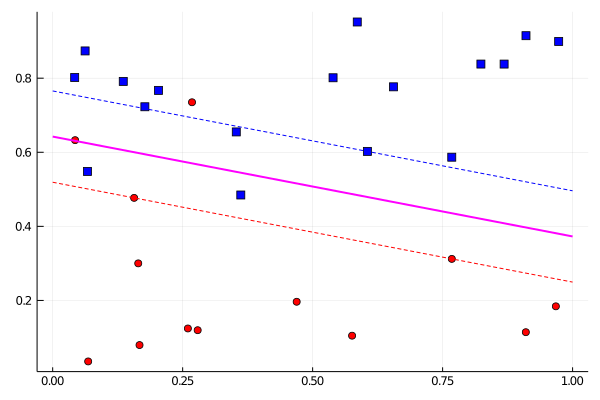

In [79]:
using JuMP, Ipopt

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)) 

@variable(model, w[1:2])
@variable(model, b)

@objective(model, Min, dot(w, w) / 2)

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1)

optimize!(model)

w, b = value.(w), value.(b)

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], 0, 1, c=:magenta, lw=:2)
plot!(x -> -(w[1] * x + b - 1) / w[2], 0, 1, c=:blue, l=:dash)
plot!(x -> -(w[1] * x + b + 1) / w[2], 0, 1, c=:red, l=:dash)

Perceba que o programa apresentou uma solução, entretanto, ao solicitarmos como ele encontrou essa solução obtemos a seguinte mensagem:

In [26]:
termination_status(model)

LOCALLY_INFEASIBLE::TerminationStatusCode = 5

Ou seja, não foi possível de resolver tal problema com a mesma formatação utilizada para o caso em que os dados são linearmente separáveis, e a solução apresentada suspeitamos que seja a mais próxima do que viria a ser uma solução ótima.

É em vista disso que se faz importante alteral o modelo utilizado anteriormente e acrescentar as variáveis de folga às restrições e à função objetivo. Vejamos como fazer isso na prática.

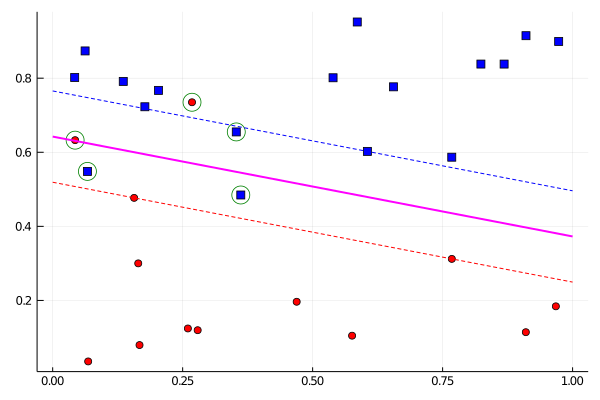

In [82]:
using JuMP, Ipopt

C = 100.0 # Quanto maior o valor deste parâmetro, maior será a penalização. 

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:2])
@variable(model, b)
@variable(model, ξ[1:n] ≥ 0)

@objective(model, Min, dot(w, w) / 2 + C * sum(ξ))

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1 - ξ[i])

optimize!(model)

w, b, ξ = value.(w), value.(b), value.(ξ)

plot(leg=false)
I = findall(ξ .> 1e-6) 
scatter!(X[I,1], X[I,2], c=:green, m=(:white, stroke(1,:green), 10))
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], 0, 1, c=:magenta, lw=:2)
plot!(x -> -(w[1] * x + b - 1) / w[2], 0, 1, c=:blue, l=:dash)
plot!(x -> -(w[1] * x + b + 1) / w[2], 0, 1, c=:red, l=:dash)

Na figura acima temos representada a solução do problema utilizando SVM com margem flexível. 

Os vetores $x^{i}$ circulados em verde são aqueles que receberam folga, isto é, $\xi_{i} >0$. E ao analisar o que ocorre com esses vetores conforme alteramos os valores para o parâmetro $C$, nota-se que caso o valor atribuído a $C$ seja pequeno mais vetores recebem folga, inclusive alguns para os quais não seria necessário. Caso contrário, se valores muito altos são atribuídos ao parâmetro $C$, o número de vetores que recebem folga diminui. Contudo, neste último caso o programa tende a se concentrar em minimizar a penalização em vez da margem na função objetivo. Devido a isso, é de suma importância escolher o valor correto para o parâmetro $C$.
$% pesquisar de que forma esse parâmetro é determinado.$

Vejamos agora um caso com os dados dispostos de maneira um pouco mais "embaralhada".

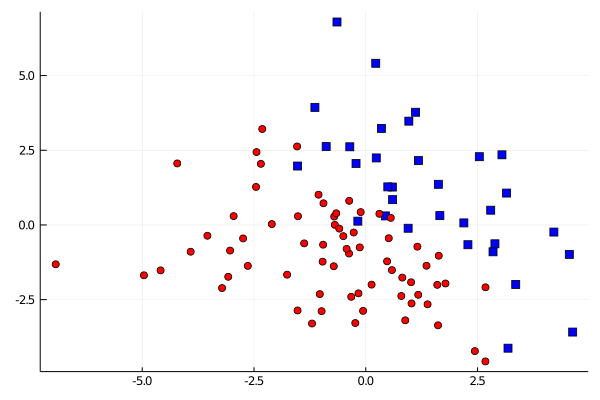

In [84]:
using Random, LinearAlgebra

Random.seed!(0)

n = 100 #quantidade de dados
X = randn(n, 2) * 2
w_sol = [0.5; 0.4]
b_sol = -0.5
y = [dot(w_sol, X[i,:]) + b_sol > randn() * 0.5 ? 1 : -1 for i = 1:n] # Aqui alteramos de 1.0 para 0.5 para tornar os dados não separáveis.

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

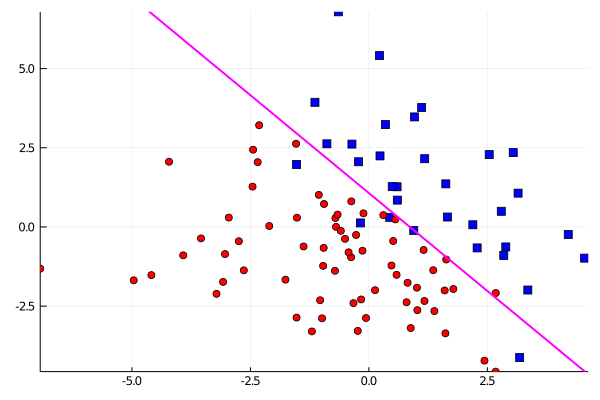

In [85]:
using JuMP, Ipopt

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)) 

@variable(model, w[1:2])
@variable(model, b)

@objective(model, Min, dot(w, w) / 2)

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1)

optimize!(model)

w, b = value.(w), value.(b)

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], extrema(X[:,1]) ..., c=:magenta, lw=:2)
xlims!(extrema(X[:,1])...)
ylims!(extrema(X[:,2])...)   

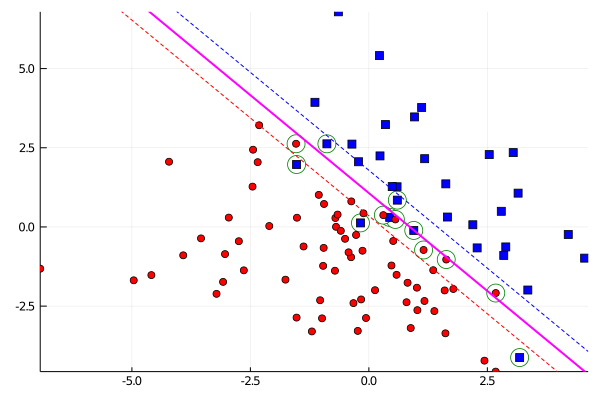

In [57]:
using JuMP, Ipopt

C = 100.0 

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)) 

@variable(model, w[1:2])
@variable(model, b)
@variable(model, ξ[1:n] ≥ 0)

@objective(model, Min, dot(w, w) / 2 + C * sum(ξ))

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1 - ξ[i])

optimize!(model)

w, b, ξ = value.(w), value.(b), value.(ξ)

plot(leg=false)
I = findall(ξ .> 1e-6) 
scatter!(X[I,1], X[I,2], c=:green, m=(:white, stroke(1,:green), 10))
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], extrema(X[:,1]) ..., c=:magenta, lw=:2)
plot!(x -> -(w[1] * x + b - 1) / w[2], extrema(X[:,1]) ..., c=:blue, l=:dash)
plot!(x -> -(w[1] * x + b + 1) / w[2], extrema(X[:,1]) ..., c=:red, l=:dash)
xlims!(extrema(X[:,1])...)
ylims!(extrema(X[:,2])...) 

Neste último exemplo, o problema possui $2 + 1 + n$ variáveis e $n$ restrições. Assim, na prática esses valores podem assumir valores muito altos, o que pode tornar sua resolução bem trabalhosa.